In [19]:
!pip install --upgrade openai --quiet


In [ ]:
from google.colab import userdata
OPEN_AI_KEY=userdata.get('opeaikey4o')
from openai import OpenAI

In [ ]:
## Set the API key and model name
MODEL="gpt-3.5-turbo"
client = OpenAI(api_key=OPEN_AI_KEY)

In [ ]:
import json
import openai
import os
import pandas as pd
from pprint import pprint
import time
import matplotlib.pyplot as plt

## Read in the dataset we'll use for this task.
## This will be the RecipesNLG dataset, which we've cleaned to only contain documents from www.cookbooks.com

In [ ]:
receipe_df=pd.read_csv('cookbook_recipes_nlg_10k.csv')
receipe_df.head()

,title,ingredients,directions,link,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,www.cookbooks.com,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,www.cookbooks.com,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,www.cookbooks.com,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,www.cookbooks.com,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,www.cookbooks.com,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [ ]:
len(receipe_df)

6229

#Data preparation
[{'role': 'system',
  'content': 'You are a helpful recipe assistant. You are to extract the generic ingredients from each of the recipes provided.'},

 {'role': 'user',
  'content': 'Title: No-Bake Nut Cookies\n\nIngredients: ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]\n\nGeneric ingredients: '},

 {'role': 'assistant',
  'content': '["brown sugar", "milk", "vanilla", "nuts", "butter", "bite size shredded rice biscuits"]'}]

In [ ]:
training_data=[]
system_message="You are a helpful recipe assitant. You are to extract the generic ingredients from each of the recipes provided"

In [ ]:
def create_user_message(row):
  return f"Title:{row['title']}\n\nIngredients:{row['ingredients']}\n\nGeneric ingredients:"


def prepare_example_conversation(row):
  messages=[]
  messages.append({"role":"system","content":system_message})

  user_message=create_user_message(row)
  messages.append({"role":"user","content":user_message})

  messages.append({"role":"assistant","content":row["NER"]})

  return {"messages":messages}

pprint(prepare_example_conversation(receipe_df.iloc[0]))

{'messages': [{'content': 'You are a helpful recipe assitant. You are to '
                          'extract the generic ingredients from each of the '
                          'recipes provided',
               'role': 'system'},
              {'content': 'Title:No-Bake Nut Cookies\n'
                          '\n'
                          'Ingredients:["1 c. firmly packed brown sugar", "1/2 '
                          'c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. '
                          'broken nuts (pecans)", "2 Tbsp. butter or '
                          'margarine", "3 1/2 c. bite size shredded rice '
                          'biscuits"]\n'
                          '\n'
                          'Generic ingredients:',
               'role': 'user'},
              {'content': '["brown sugar", "milk", "vanilla", "nuts", '
                          '"butter", "bite size shredded rice biscuits"]',
               'role': 'assistant'}]}


Note:In last assitant is the outuput data

Let's now do this for a subset of the dataset to use as our training data. You can begin with even 30-50 well-pruned examples. You should see performance continue to scale linearly as you increase the size of the training set, but your jobs will also take longer.

## use the first 100 rows of the dataset for training


In [ ]:
training_df=receipe_df.iloc[:100]
training_df.head()

,title,ingredients,directions,link,source,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,www.cookbooks.com,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,www.cookbooks.com,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,www.cookbooks.com,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,www.cookbooks.com,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,www.cookbooks.com,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


### apply the prepare_example_conversation function to each row of the training_df


In [ ]:
trainig_data=training_df.apply(prepare_example_conversation,axis=1).tolist()

for example in trainig_data[:5]:
  print(example)

{'messages': [{'role': 'system', 'content': 'You are a helpful recipe assitant. You are to extract the generic ingredients from each of the recipes provided'}, {'role': 'user', 'content': 'Title:No-Bake Nut Cookies\n\nIngredients:["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]\n\nGeneric ingredients:'}, {'role': 'assistant', 'content': '["brown sugar", "milk", "vanilla", "nuts", "butter", "bite size shredded rice biscuits"]'}]}
{'messages': [{'role': 'system', 'content': 'You are a helpful recipe assitant. You are to extract the generic ingredients from each of the recipes provided'}, {'role': 'user', 'content': 'Title:Jewell Ball\'S Chicken\n\nIngredients:["1 small jar chipped beef, cut up", "4 boned chicken breasts", "1 can cream of mushroom soup", "1 carton sour cream"]\n\nGeneric ingredients:'}, {'role': 'assistant', 'content': '["beef", "chick

### optionally provide validation data,

In [ ]:
validation_df=receipe_df.iloc[101:200]

validation_data=validation_df.apply(prepare_example_conversation,axis=1).tolist()

### We then need to save our data as .jsonl files, with each line being one training example conversation.



In [ ]:
def write_jsonl(data_list:list,filename:str):
  with open(filename,"w") as out:
    for data in data_list:
      jout=json.dumps(data)+"\n"
      out.write(jout)



In [ ]:
training_file_name="receipe_fine_tune_training.jsonl"
write_jsonl(trainig_data,training_file_name)

validation_file_name="receipe_fine_tune_validation.jsonl"
write_jsonl(validation_data,validation_file_name)

#### print the first 5 lines of the training file

In [20]:
!head -n 5 receipe_fine_tune_training.jsonl

{"messages": [{"role": "system", "content": "You are a helpful recipe assitant. You are to extract the generic ingredients from each of the recipes provided"}, {"role": "user", "content": "Title:No-Bake Nut Cookies\n\nIngredients:[\"1 c. firmly packed brown sugar\", \"1/2 c. evaporated milk\", \"1/2 tsp. vanilla\", \"1/2 c. broken nuts (pecans)\", \"2 Tbsp. butter or margarine\", \"3 1/2 c. bite size shredded rice biscuits\"]\n\nGeneric ingredients:"}, {"role": "assistant", "content": "[\"brown sugar\", \"milk\", \"vanilla\", \"nuts\", \"butter\", \"bite size shredded rice biscuits\"]"}]}
{"messages": [{"role": "system", "content": "You are a helpful recipe assitant. You are to extract the generic ingredients from each of the recipes provided"}, {"role": "user", "content": "Title:Jewell Ball'S Chicken\n\nIngredients:[\"1 small jar chipped beef, cut up\", \"4 boned chicken breasts\", \"1 can cream of mushroom soup\", \"1 carton sour cream\"]\n\nGeneric ingredients:"}, {"role": "assistan

#Upload files
You can now upload the files to our Files endpoint to be used by the fine-tuned model.



In [21]:
with open(training_file_name,"rb") as training_fd:
  training_response=client.files.create(
      file=training_fd,
      purpose="fine-tune"
  )

training_file_id=training_response.id



In [22]:
with open(validation_file_name,"rb") as validation_fd:
  validation_response=client.files.create(
      file=validation_fd,
      purpose="fine-tune"
  )

validation_file_id=validation_response.id

In [23]:
print("Training file Id: ",training_file_id)
print("Validation file Id: ",validation_file_id)

Training file Id:  file-0zBgykpq9Jhk6ORQsinLBRuU
Validation file Id:  file-hcp4OyO0CabLhddoglWWN05z


#Fine-tuning


fine_tunning_job_auto=client.fine_tuning.jobs.create(
    training_file=data_file.id,
    model='gpt-3.5-turbo',
    hyperparameters={
        "n_epochs":'auto'
    }
)

In [24]:
response=client.fine_tuning.jobs.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model=MODEL
)

In [25]:
job_id=response.id
print("Job Id",job_id)
print("Status",response.status)

Job Id ftjob-wlzP8gMpBIUnTDr2DW9bEmQ5
Status validating_files


# Check job status
You can make a GET request to the https://api.openai.com/v1/alpha/fine-tunes endpoint to list your alpha fine-tune jobs. In this instance you'll want to check that the ID you got from the previous step ends up as status: succeeded.

In [31]:
response=client.fine_tuning.jobs.retrieve(job_id)
print("Job Id",response.id)
print("Status",response.status)
print("Trained Token:",response.trained_tokens)

Job Id ftjob-wlzP8gMpBIUnTDr2DW9bEmQ5
Status succeeded
Trained Token: 39132


In [28]:
while True:
  time.sleep(5)
  retrieved_jobs_auto=client.fine_tuning.jobs.retrieve(job_id)
  status=retrieved_jobs_auto.status
  print(status)
  if(status=='succeeded'):
    print("Job Id",response.id)
    print("Status",response.status)
    print("Trained Token:",response.trained_tokens)
    break

running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running


We can track the progress of the fine-tune with the events endpoint. You can rerun the cell below a few times until the fine-tune is ready.



In [32]:
response=client.fine_tuning.jobs.list_events(job_id)
events=response.data
events.reverse()

for event in events:
  print(event)

FineTuningJobEvent(id='ftevent-YKZRvYGSLIuh5cfATEGxNVSR', created_at=1720202571, level='info', message='Step 285/300: training loss=0.00', object='fine_tuning.job.event', data={'step': 285, 'train_loss': 3.6679782056125987e-07, 'total_steps': 300, 'train_mean_token_accuracy': 1.0}, type='metrics')
FineTuningJobEvent(id='ftevent-WeUE7yldGvMXxsST057Qvufz', created_at=1720202573, level='info', message='Step 286/300: training loss=0.16', object='fine_tuning.job.event', data={'step': 286, 'train_loss': 0.15828396379947662, 'total_steps': 300, 'train_mean_token_accuracy': 0.970588207244873}, type='metrics')
FineTuningJobEvent(id='ftevent-wVxAZaHfNN8PGen8znQ9EWKa', created_at=1720202576, level='info', message='Step 287/300: training loss=0.00', object='fine_tuning.job.event', data={'step': 287, 'train_loss': 5.201860062697961e-07, 'total_steps': 300, 'train_mean_token_accuracy': 1.0}, type='metrics')
FineTuningJobEvent(id='ftevent-pYNULgAKeypiDkRSot1Hqm9H', created_at=1720202579, level='info'

In [33]:
steps=[]
train_loss=[]
for e in events:
  if(e.data):
    steps.append(e.data['step'])
    train_loss.append(e.data['train_loss'])
print(steps)
print(train_loss)

[285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300]
[3.6679782056125987e-07, 0.15828396379947662, 5.201860062697961e-07, 3.076368670917873e-07, 0.2018033117055893, 0.04346422478556633, 0.0006203858647495508, 0.08998546749353409, 4.6394967512242147e-07, 3.178914482759865e-07, 5.019338686906849e-07, 0.024969881400465965, 0.47933635115623474, 4.541306282135338e-07, 6.543265772052109e-05, 0.25606074929237366]


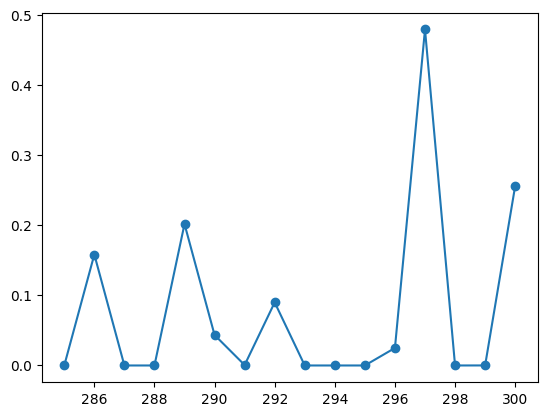

In [34]:
plt.plot(steps,train_loss,marker='o',linestyle='-')

In [35]:
response = client.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = response.fine_tuned_model

if fine_tuned_model_id is None:
    raise RuntimeError("Fine-tuned model ID not found. Your job has likely not been completed yet.")

print("Fine-tuned model ID:", fine_tuned_model_id)

Fine-tuned model ID: ft:gpt-3.5-turbo-0125:personal::9hhZP51v


# Inference
The last step is to use your fine-tuned model for inference. Similar to the classic FineTuning, you simply call ChatCompletions with your new fine-tuned model name filling the model parameter.



In [36]:
test_df=receipe_df[201:300]
test_row=test_df.iloc[0]
test_messages=[]

test_messages.append({"role":"system", "content":system_message})
user_messages=create_user_message(test_row)
test_messages.append({"role":"user", "content":user_messages})

pprint(test_messages)


[{'content': 'You are a helpful recipe assitant. You are to extract the '
             'generic ingredients from each of the recipes provided',
  'role': 'system'},
 {'content': 'Title:Beef Brisket\n'
             '\n'
             'Ingredients:["4 lb. beef brisket", "1 c. catsup", "1 c. water", '
             '"1/2 onion, minced", "2 Tbsp. cider vinegar", "1 Tbsp. prepared '
             'horseradish", "1 Tbsp. prepared mustard", "1 tsp. salt", "1/2 '
             'tsp. pepper"]\n'
             '\n'
             'Generic ingredients:',
  'role': 'user'}]


In [37]:
response=client.chat.completions.create(
    model=fine_tuned_model_id,
    messages=test_messages,
    temperature=0,
    max_tokens=500
)

print(response.choices[0].message.content)

["beef brisket", "catsup", "water", "onion", "cider vinegar", "horseradish", "mustard", "salt", "pepper"]


In [38]:
test_df.head()

,title,ingredients,directions,link,source,NER
201,Beef Brisket,"[""4 lb. beef brisket"", ""1 c. catsup"", ""1 c. wa...","[""Mix catsup, water, onion, vinegar, horseradi...",www.cookbooks.com/Recipe-Details.aspx?id=1007920,www.cookbooks.com,"[""beef brisket"", ""catsup"", ""water"", ""onion"", ""..."
202,Fruit Medley,"[""3 Tbsp. tapioca"", ""1 c. water"", ""1/2 c. suga...","[""Allow tapioca, 1 cup water and sugar to stan...",www.cookbooks.com/Recipe-Details.aspx?id=399,www.cookbooks.com,"[""tapioca"", ""water"", ""sugar"", ""water"", ""orange..."
203,Nana'S Cornbread(For 9-Inch Iron Skillet Or 8 ...,"[""1 c. corn meal"", ""1 c. flour"", ""1 to 2 Tbsp....","[""Stir 1/2 teaspoon baking soda into 1 cup but...",www.cookbooks.com/Recipe-Details.aspx?id=917184,www.cookbooks.com,"[""corn meal"", ""flour"", ""sugar"", ""salt"", ""bakin..."
204,Marinated Pork Roast,"[""1 (4 to 5 lb.) rolled pork roast"", ""1/2 c. s...","[""Combine all ingredients except roast."", ""Pla...",www.cookbooks.com/Recipe-Details.aspx?id=791287,www.cookbooks.com,"[""pork roast"", ""sherry"", ""mustard"", ""thyme"", ""..."
205,Dad'S Chili,"[""2 lb. pork tenderloin, cubed"", ""1 Tbsp. oil""...","[""Fry pork in oil in saucepan over medium heat...",www.cookbooks.com/Recipe-Details.aspx?id=623857,www.cookbooks.com,"[""pork tenderloin"", ""oil"", ""garlic"", ""green ch..."
